c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\chamy\AppData\Local\Temp/ipykernel_16080/425366031.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 43.0 Best Reward 43.0 Last Reward 43.0 Epsilon 1.0
Episode 2 Average Reward 28.5 Best Reward 43.0 Last Reward 14.0 Epsilon 1.0
Episode 3 Average Reward 22.333333333333332 Best Reward 43.0 Last Reward 10.0 Epsilon 0.996005996001
Episode 4 Average Reward 24.25 Best Reward 43.0 Last Reward 30.0 Epsilon 0.9665550620990835
Episode 5 Average Reward 26.4 Best Reward 43.0 Last Reward 35.0 Epsilon 0.933294459381294
Episode 6 Average Reward 26.666666666666668 Best Reward 43.0 Last Reward 28.0 Epsilon 0.9075119613694457
Episode 7 Average Reward 24.714285714285715 Best Reward 43.0 Last Reward 13.0 Epsilon 0.8957848329039134
Episode 8 Average Reward 24.75 Best Reward 43.0 Last Reward 25.0 Epsilon 0.8736568985103146
Episode 9 Average Reward 23.22222222222222 Best Reward 43.0 Last Reward 11.0 Epsilon 0.8640945798906344


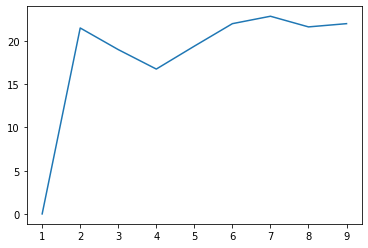

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1', render_mode = 'human')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 10
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001

FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device("cpu")

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []


class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros(
            (MEM_SIZE, *env.observation_space.shape), dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros(
            (MEM_SIZE, *env.observation_space.shape), dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index] = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] = 1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones = self.dones[batch_indices]

        return states, actions, rewards, states_, dones


class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return env.action_space.sample()

        state = torch.tensor(observation).float().detach()
        state = state.to(DEVICE)
        state = state.unsqueeze(0)
        q_values = self.network(state)
        return torch.argmax(q_values).item()

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states, dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]

        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate


agent = DQN_Solver()

for i in range(1, EPISODES):
    state = env.reset()
    state = np.reshape(state[0], [1, observation_space])
    score = 0

    while True:
        env.render()
        action = agent.choose_action(state)
        state_, reward, done, info, _ = env.step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(
                i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)

plt.plot(episode_number, average_reward_number)
plt.show()
